In [1]:
#!pip install numpy==1.19.5

In [2]:
#importing libraries 
import plotly.offline as pyo
pyo.init_notebook_mode()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2 
from plotly.subplots import make_subplots
import plotly.graph_objects as go
from sklearn import preprocessing
import random
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16, decode_predictions, preprocess_input
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten , Conv1D, GlobalAveragePooling2D,Reshape,Dropout
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Conv2D, Bidirectional, LSTM
from tensorflow.keras.layers import MaxPooling2D,MaxPooling1D
from tensorflow.keras.utils import plot_model
import warnings
import re
warnings.filterwarnings("ignore")
#!pip install visualkeras

In [3]:
#setting up file path variables
ROOT_PATH = '.'
DATA_PATH = f'{ROOT_PATH}/full_df.csv'
TRAINING_DATA_PATH = f'{ROOT_PATH}/ODIR-5K/ODIR-5K/data.xlsx'
IMG_PRE_PROCESSED_DIR = f'{ROOT_PATH}/preprocessed_images'
IMG_train_DIR = f'{ROOT_PATH}kaggle_ocular/TrainingImages/'
IMG_test_DIR = f'{ROOT_PATH}kaggle_ocular/TestingImages/'

In [4]:
#function to load datasetfile
def dataframe_creation():
    df4 = pd.read_csv(f'{ROOT_PATH}/full_df.csv')
    df4['filename']=f'{ROOT_PATH}'+'/preprocessed_images/'+df4['filename']
    df4['Left-Fundus']=f'{ROOT_PATH}'+'/preprocessed_images/'+df4['Left-Fundus']
    df4['Right-Fundus']=f'{ROOT_PATH}'+'/preprocessed_images/'+df4['Right-Fundus']
    df4['Line'] = df4['Left-Diagnostic Keywords']+' | '+df4['Right-Diagnostic Keywords']
    df4 = df4.drop(['filepath','target'], axis=1)
    return df4
df = dataframe_creation()
print(df.shape)
df.head()

(6392, 18)


ID  Patient Age Patient Sex                       Left-Fundus  \
0   0           69      Female  ./preprocessed_images/0_left.jpg   
1   1           57        Male  ./preprocessed_images/1_left.jpg   
2   2           42        Male  ./preprocessed_images/2_left.jpg   
3   4           53        Male  ./preprocessed_images/4_left.jpg   
4   5           50      Female  ./preprocessed_images/5_left.jpg   

                        Right-Fundus  \
0  ./preprocessed_images/0_right.jpg   
1  ./preprocessed_images/1_right.jpg   
2  ./preprocessed_images/2_right.jpg   
3  ./preprocessed_images/4_right.jpg   
4  ./preprocessed_images/5_right.jpg   

                            Left-Diagnostic Keywords  \
0                                           cataract   
1                                      normal fundus   
2  laser spot，moderate non proliferative retinopathy   
3                        macular epiretinal membrane   
4             moderate non proliferative retinopathy   

                Right-Diagnostic Keywords  N  D  G  C  A  H  M  O labels  \
0                           normal fundus  0  0  0  1  0  0  0  0  ['N']   
1                           normal fundus  1  0  0  0  0  0  0  0  ['N']   
2  moderate non proliferative retinopathy  0  1  0  0  0  0  0  1  ['D']   
3       mild nonproliferative retinopathy  0  1  0  0  0  0  0  1  ['D']   
4  moderate non proliferative retinopathy  0  1  0  0  0  0  0  0  ['D']   

                            filename  \
0  ./preprocessed_images/0_right.jpg   
1  ./preprocessed_images/1_right.jpg   
2  ./preprocessed_images/2_right.jpg   
3  ./preprocessed_images/4_right.jpg   
4  ./preprocessed_images/5_right.jpg   

                                                Line  
0                           cataract | normal fundus  
1                      normal fundus | normal fundus  
2  laser spot，moderate non proliferative retinopa...  
3  macular epiretinal membrane | mild nonprolifer...  
4  moderate non proliferative retinopathy | moder...

# Visualize Data

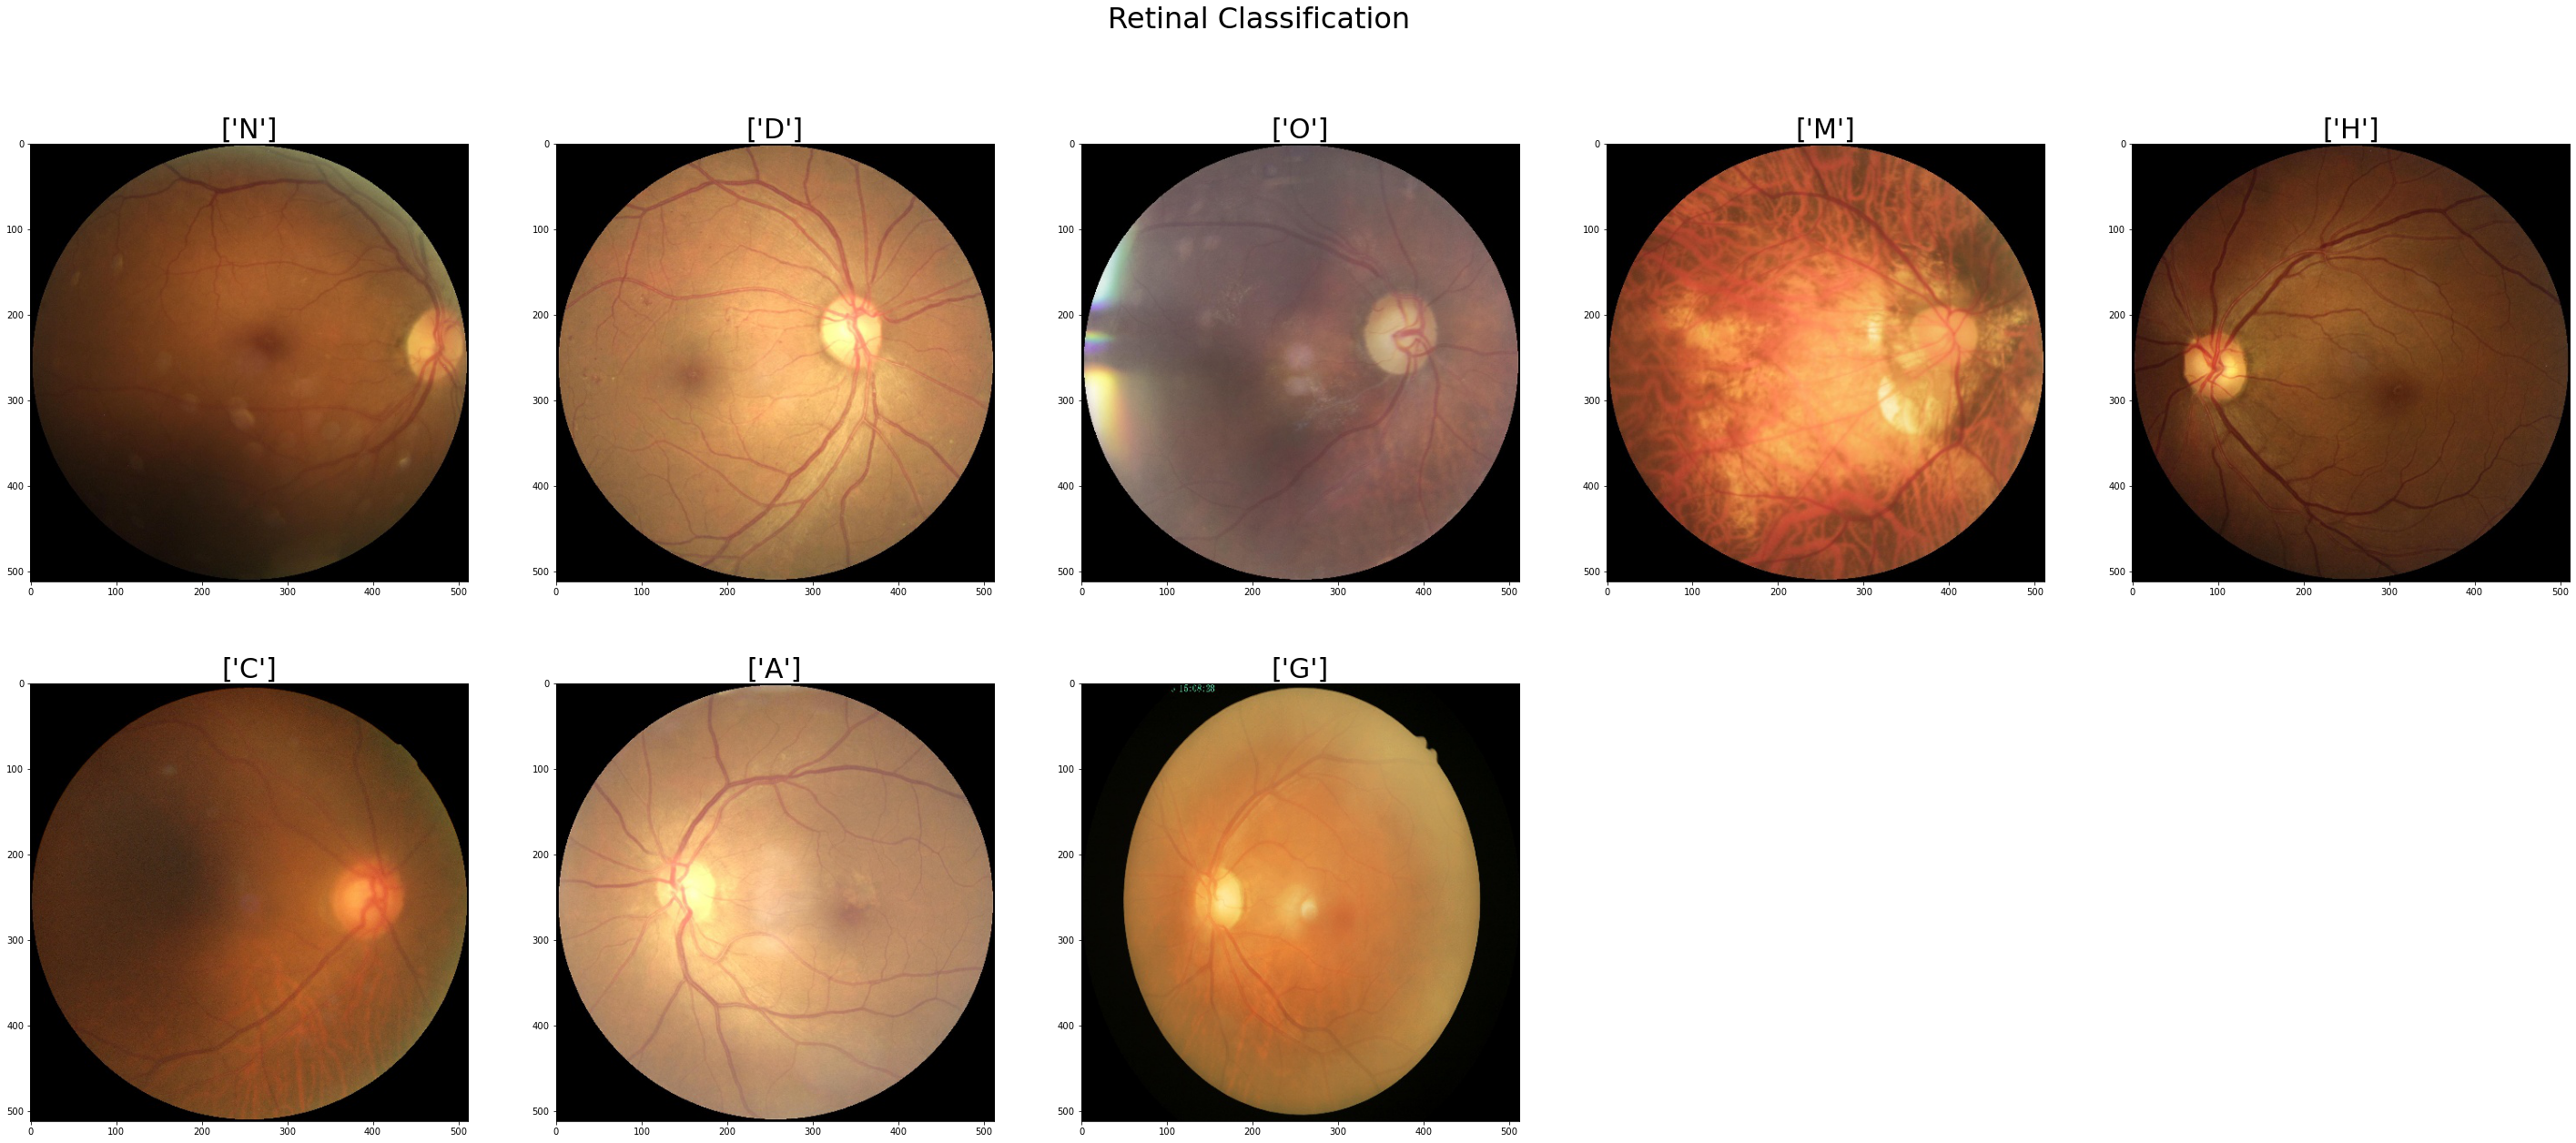

In [5]:
#Loading sample images from various classes
count = 1
f = plt.figure(figsize=(50,20))
for Class in df['labels'].unique():
    seg = df[df['labels']==Class]
    address = seg.sample().iloc[0]['filename']
    img = cv2.imread(address)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #print(img)
    ax = f.add_subplot(2, 5,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Retinal Classification", size = 32)
plt.show()

In [6]:
#setting vgg16 compatible height and width for images
w , h= 224,224
final_class = 8

In [7]:
# finding records where both left and right eye images do not exist
listImg = os.listdir(f'{ROOT_PATH}/preprocessed_images')
string = f'{ROOT_PATH}/preprocessed_images/'
list2 = list(map(lambda orig_string: string + orig_string , listImg))
indexify =[]
for i in df.index:
    if df.iloc[i]['Left-Fundus'] in list2 and df.iloc[i]['Right-Fundus'] in list2:
        continue
    else:
        indexify.append(i)

In [8]:
# removing those paitents for which left and right both images do not exist
print(df.shape)
df = df.drop(indexify)
print(df.shape)
df.reset_index(inplace= True)

(6392, 18)
(6068, 18)


In [9]:
print(df.index)

RangeIndex(start=0, stop=6068, step=1)


In [10]:
# finding duplicate paitent entries 
existing =[]
indexify =[]
for i in df.index:
    
    if df.iloc[i]['ID'] in existing:
        indexify.append(i)
    else:
        existing.append(df.iloc[i]['ID'])
    


In [11]:
#deleting duplciate entries
print(df.shape)
df = df.drop(indexify)
print(df.shape)
df.reset_index(inplace= True)

(6068, 19)
(3034, 19)


In [12]:
# changing color space of images and applying interpolation to preserve image quality
# and storing let and right images in X1 and X2 array respectively 
from tqdm import tqdm
left = []
index=0
for location in tqdm(df.iloc[:]['Left-Fundus']):
    img = cv2.imread(location)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_LINEAR)
    img = img.reshape(w,h,3)   
    left.append(img)
    index = index +1
right = []
for location in tqdm(df.iloc[:]['Right-Fundus']):
    img = cv2.imread(location)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_LINEAR)
    img = img.reshape(w,h,3)
    right.append(img)
X1 = np.array(left)
X2 = np.array(right)

100%|██████████| 3034/3034 [00:23<00:00, 128.93it/s]


In [13]:
print(X1.shape)
print(X2.shape)

(3034, 224, 224, 3)
(3034, 224, 224, 3)


In [14]:
# building target variable 'y' by combining  binary label columns
from sklearn.preprocessing import OneHotEncoder
y = np.array(df.iloc[:][['N','D','G','C','A','H','M','O']])
y = np.array(y)
print('Label :   '+str(y.shape))

Label :   (3034, 8)


In [15]:
# creating the model
def model_b():
    inp1 = Input(shape=(X1.shape[1],X1.shape[2],3,))
    inp2 = Input(shape=(X2.shape[1],X2.shape[2],3,))
    new_input = Input(shape=(X1.shape[1],X1.shape[2], 3))
    
    conv1 = Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp1)    
    rightEyeFeatureExtractionModel = VGG16(weights='imagenet',include_top=False,input_tensor=new_input,input_shape = None, pooling='avg')
    rightEyeFeatureExtractionModel.trainable=False
    for layer in rightEyeFeatureExtractionModel.layers:
        if(re.match(r"^input", layer.name)):
            
            layer._name = 'input' + str('_R')
        else:
            layer._name = layer.name + str('_R')
    i1 = rightEyeFeatureExtractionModel(conv1)
    print(conv1.name)
    
    
    conv2= Conv2D(3, kernel_size=3, padding ='same', activation='relu')(inp2)
    leftEyeFeatureExtractionModel = VGG19(weights='imagenet',include_top=False,input_tensor=new_input,input_shape = None, pooling='avg')  
    leftEyeFeatureExtractionModel.trainable = False
    for layer in leftEyeFeatureExtractionModel.layers:
        if(re.match(r"^input", layer.name)):            
            layer._name = 'input' + str('_L')
        else:
            layer._name = layer.name + str('_L')
    
    i2=leftEyeFeatureExtractionModel(conv2)
    
    print(conv2.name)
    
    merge = concatenate([i1,i2])
   
    class1 = Reshape(target_shape= (1,merge.shape[1]))(merge)    
    class1 = Bidirectional (LSTM(1024, dropout=0.2))(class1)    
    output = Dense(final_class, activation='sigmoid')(class1)
    model = Model(inputs=[inp1,inp2], outputs=output)
    
    return model
    

md = model_b()

conv2d/Relu:0
conv2d_1/Relu:0


In [16]:
md.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 3)  84          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 3)  84          input_2[0][0]                    
______________________________________________________________________________________________

# Train Test Splitting

In [17]:
from sklearn.model_selection import train_test_split
Left_train, Left_test, Right_train, Right_test, y_train, y_test = train_test_split(X1,X2, y, test_size=0.20, random_state=42)

In [18]:
Left_train, Left_valid, Right_train, Right_valid, y_train, y_valid  = train_test_split(Left_train,Right_train, y_train, test_size=0.20, random_state=42)

In [19]:
print(Left_train.shape)
print(Left_test.shape)
print(Left_valid.shape)

(1941, 224, 224, 3)
(607, 224, 224, 3)
(486, 224, 224, 3)


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,ReduceLROnPlateau
# function to reduce learning rate when validation loss becomes stagnant
def get_LR_checkpoint(lr_factor=0.2,lr_patience=4,lr_min=0.00001):
    return ReduceLROnPlateau(monitor='val_loss',factor=lr_factor,verbose=1,patience=lr_patience,min_lr=lr_min)
# function to store model 
def get_model_checkpoint():
    checkpoint = ModelCheckpoint('ODIR_vgg16_19_bilstm18Nov.h5', monitor='val_loss', verbose=1,save_best_only=True, mode='auto', save_freq='epoch')
    return checkpoint
# callback function combining both the above functions to be used during model training
def get_callbacks(lr_factor=0.2,lr_patience=4,lr_min=0.00001):
    checkpoint= get_model_checkpoint()
    LR= get_LR_checkpoint(lr_factor,lr_patience,lr_min)
    callbacks_list = [LR]
    return callbacks_list

In [21]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
# function to train model
def LR_verify():
        model = model_b()
        METRICS = [
                'accuracy'
        ]  
        model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
        
        history = model.fit([Left_train,Right_train], y_train, epochs=150,verbose=1,shuffle = True,batch_size=91,
                            validation_data=([Left_valid,Right_valid],y_valid),callbacks=get_callbacks()                          
                    )
        return model,history
#training the model
model,history= LR_verify()

conv2d_2/Relu:0
conv2d_3/Relu:0
Epoch 1/150
22/22 [==============================] - 128s 4s/step - loss: 0.4314 - accuracy: 0.3092 - val_loss: 0.3282 - val_accuracy: 0.3992
Epoch 2/150
22/22 [==============================] - 19s 882ms/step - loss: 0.3127 - accuracy: 0.4557 - val_loss: 0.3266 - val_accuracy: 0.3560
Epoch 3/150
22/22 [==============================] - 19s 881ms/step - loss: 0.3041 - accuracy: 0.4483 - val_loss: 0.3190 - val_accuracy: 0.4403
Epoch 4/150
22/22 [==============================] - 19s 881ms/step - loss: 0.2866 - accuracy: 0.5120 - val_loss: 0.3076 - val_accuracy: 0.4321
Epoch 5/150
22/22 [==============================] - 19s 880ms/step - loss: 0.2831 - accuracy: 0.5036 - val_loss: 0.3076 - val_accuracy: 0.4588
Epoch 6/150
22/22 [==============================] - 19s 881ms/step - loss: 0.2736 - accuracy: 0.5278 - val_loss: 0.2998 - val_accuracy: 0.4465
Epoch 7/150
22/22 [==============================] - 19s 880ms/step - loss: 0.2669 - accuracy: 0.5339 - va

In [22]:
# visualise accuracy during training 
def plot_history_acc(history):
    
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc="lower right")
    plt.show() 
    
# visualise loss during training    
def plot_history_loss(history):
    
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc="lower right")
    plt.show()     

# plot confusion matrix 
def plotConfuxionMatrix(disease, cm):
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Negative','Positive']
    plt.title(f' Confusion Matrix for Label: {disease}')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames, rotation=45)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]

    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()    

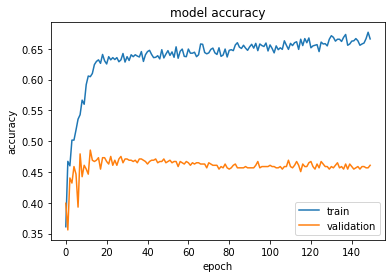

In [23]:
plot_history_acc(history)

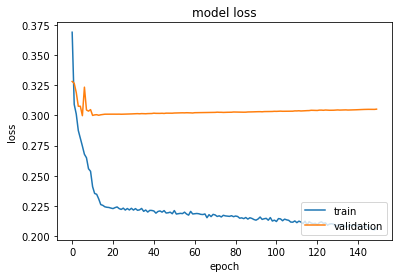

In [24]:
plot_history_loss(history)

model.save("ODIR_vgg_BiLSTM")

In [25]:
#from tensorflow.keras.models import model_from_json
#model_json = model.to_json()
#name = 'ODIR_vgg16_19_bilstm5Nov'
#with open(name+".json", "w") as json_file:
#    json_file.write(model_json)
#model.save_weights(name+".h5")
import pandas as pd
hist_df = pd.DataFrame(history.history) 
#hist_df.to_csv(name+'.csv',index = False)
hist_df.tail()

loss  accuracy  val_loss  val_accuracy       lr
145  0.206753  0.657908  0.305051      0.458848  0.00001
146  0.206452  0.659454  0.305025      0.458848  0.00001
147  0.205563  0.666667  0.305047      0.456790  0.00001
148  0.205105  0.676971  0.305019      0.456790  0.00001
149  0.206877  0.666151  0.305208      0.460905  0.00001

In [26]:
loaded_model =  model

# Results

## Model perfomance on validation set

In [27]:
METRICS = [
                'accuracy',
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.TruePositives()
        ]  
loaded_model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([Left_valid,Right_valid], y_valid, verbose=0)

In [28]:
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.30520787835121155
accuracy : 0.4609053432941437
false_negatives : 378.0
false_positives : 167.0
precision : 0.5308988690376282
recall : 0.3333333432674408
true_negatives : 3154.0
true_positives : 189.0


In [29]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, multilabel_confusion_matrix
import pandas as pd
yhat = loaded_model.predict([Left_valid,Right_valid])
yhat = yhat.round()
report = classification_report(y_valid, yhat,target_names=['N','D','G','C','A','H','M','O'],output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
N              0.503937  0.400000  0.445993    160.0
D              0.467290  0.331126  0.387597    151.0
G              0.666667  0.243902  0.357143     41.0
C              0.821429  0.741935  0.779661     31.0
A              0.333333  0.090909  0.142857     22.0
H              0.500000  0.052632  0.095238     19.0
M              0.900000  0.720000  0.800000     25.0
O              0.411765  0.177966  0.248521    118.0
micro avg      0.530899  0.333333  0.409534    567.0
macro avg      0.575553  0.344809  0.407126    567.0
weighted avg   0.514832  0.333333  0.393256    567.0
samples avg    0.358711  0.347394  0.343759    567.0

## Model perfomance on Test set

In [30]:
METRICS = [
                'accuracy',
                tf.keras.metrics.FalseNegatives(),
                tf.keras.metrics.FalsePositives(),
                tf.keras.metrics.Precision(),
                tf.keras.metrics.Recall(),
                tf.keras.metrics.TrueNegatives(),
                tf.keras.metrics.TruePositives()
        ]  
loaded_model.compile(
                optimizer='Adam',
                loss='binary_crossentropy',
                metrics=METRICS
            )
score = loaded_model.evaluate([Left_test,Right_test], y_test, verbose=0)

In [31]:
for i in range(len(score)):
    print(loaded_model.metrics_names[i]+" : "+str(score[i]))

loss : 0.2829887866973877
accuracy : 0.4777594804763794
false_negatives_1 : 443.0
false_positives_1 : 193.0
precision_1 : 0.5662921071052551
recall_1 : 0.36258992552757263
true_negatives_1 : 3968.0
true_positives_1 : 252.0


In [32]:
yhat = loaded_model.predict([Left_test,Right_test])
yhat = yhat.round()
report = classification_report(y_test, yhat,target_names=['N','D','G','C','A','H','M','O'],output_dict=True)
df = pd.DataFrame(report).transpose()
df

precision    recall  f1-score  support
N              0.546099  0.390863  0.455621    197.0
D              0.497041  0.403846  0.445623    208.0
G              0.533333  0.242424  0.333333     33.0
C              0.823529  0.666667  0.736842     42.0
A              0.875000  0.218750  0.350000     32.0
H              1.000000  0.041667  0.080000     24.0
M              0.870968  0.900000  0.885246     30.0
O              0.434783  0.155039  0.228571    129.0
micro avg      0.566292  0.362590  0.442105    695.0
macro avg      0.697594  0.377407  0.439405    695.0
weighted avg   0.571756  0.362590  0.422385    695.0
samples avg    0.390445  0.380011  0.376991    695.0

In [33]:
#df.to_csv('Class_Wise_Accuracy_VGG_bilstm5Nov')


In [34]:
# Generating multi-label classification report and confusion metrics
# C00 = true negatives , C10=false Negatives, C11 = true positives,C01 =false positves 
from sklearn.metrics import multilabel_confusion_matrix
cm = multilabel_confusion_matrix(y_test, yhat)
print(cm)

[[[346  64]
  [120  77]]

 [[314  85]
  [124  84]]

 [[567   7]
  [ 25   8]]

 [[559   6]
  [ 14  28]]

 [[574   1]
  [ 25   7]]

 [[583   0]
  [ 23   1]]

 [[573   4]
  [  3  27]]

 [[452  26]
  [109  20]]]


### Plotting confusion matrix

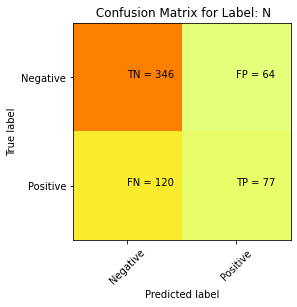

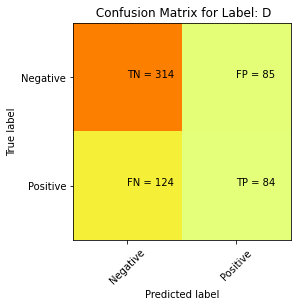

In [35]:
plotConfuxionMatrix('N', cm[0])
plotConfuxionMatrix('D', cm[1])


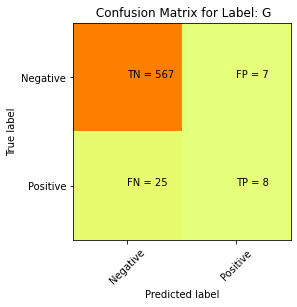

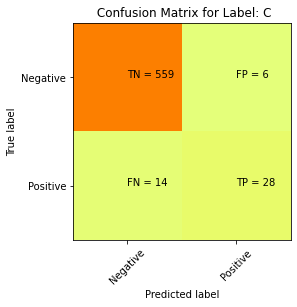

In [36]:
plotConfuxionMatrix('G', cm[2])
plotConfuxionMatrix('C', cm[3])


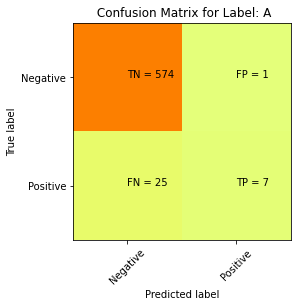

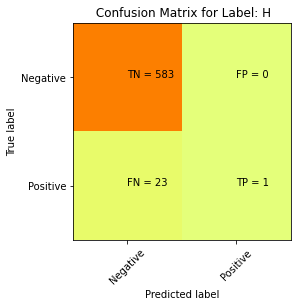

In [37]:
plotConfuxionMatrix('A', cm[4])
plotConfuxionMatrix('H', cm[5])


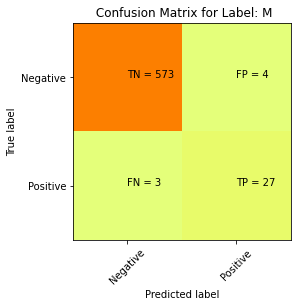

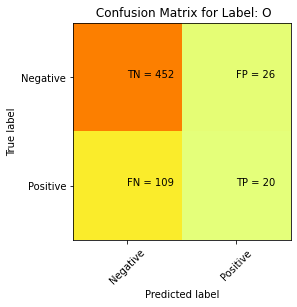

In [38]:
plotConfuxionMatrix('M', cm[6])
plotConfuxionMatrix('O', cm[7])